In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from flask import Flask, jsonify
results = session.query(Measurement.station).all()
results[0][0]

'USC00519397'

# Exploratory Climate Analysis

In [11]:
# Get column name of table measurement
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

<Figure size 1080x864 with 0 Axes>

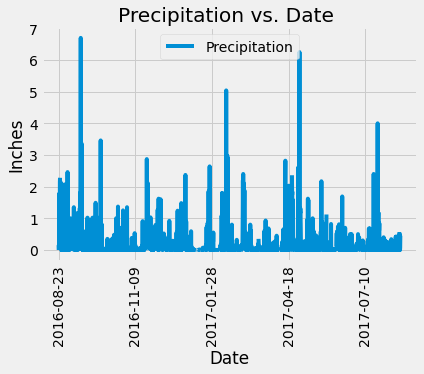

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores
prcp_12 = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_12, columns = ["Precipitation", "Date"])
prcp_df = prcp_df.set_index('Date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# Set Plot Size
plt.figure(figsize = (15,12))

# Plot
prcp_df.plot(y='Precipitation', use_index = True)
plt.xticks(rotation = 90)
plt.ylabel('Inches')
plt.title('Precipitation vs. Date ')

# Display graph
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Get column name of table station
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [15]:
# Design a query to show how many stations are available in this dataset?
# Station available
session.query(Measurement.station).group_by(Measurement.station).all()

# Determine number of stations
session.query(Measurement).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
session.query(*sel).group_by(Measurement.station).order_by(sel[1].desc()).all()

# Most active station is station USC00519281

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
active_station = active_station[0]

# Lowest Temperature for most active station
session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_station).all()

# Highest Temperature for most active station
session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_station).all()

# Average Temperature for most active station
session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station).all()

[(71.66378066378067)]

In [18]:
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs) ]
results = session.query(*sel).filter(Measurement.date >= "2016-08-23").all()
results

[(58.0, 87.0, 74.59058295964125)]

<Figure size 1080x864 with 0 Axes>

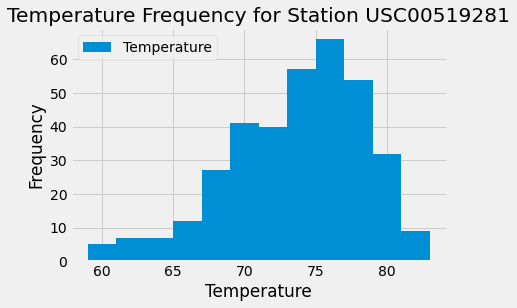

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, func.count(Measurement.tobs)]
station_temp = session.query(*sel).group_by(Measurement.station).order_by(sel[1].desc()).first()
station_temp = station_temp[0]

# Determine last date for the most active station
last_station_date = session.query(Measurement.date).filter(Measurement.station == station_temp).order_by(Measurement.date.desc()).first()
last_station_date = last_station_date[0]

# Calculate the last 12 months of last date
last_station_date = dt.datetime.strptime(last_station_date, '%Y-%m-%d') - dt.timedelta(days = 366)

temp = session.query(Measurement.tobs).filter(Measurement.station == station_temp).filter(Measurement.date > last_station_date).all()
temp = pd.DataFrame(temp, columns = ['Temperature'])
temp.head()

# Set plot size
plt.figure(figsize = (15,12))

# Plot Histogram
temp.plot.hist('Temperature', bins = 12)
plt.xlabel('Temperature')
plt.title(f'Temperature Frequency for Station {station_temp}')

# Display plot
plt.show()

## Bonus Challenge Assignment

In [62]:
# Tempearture Analysis I
import scipy.stats as stats
measure_df = pd.read_csv('Resources/hawaii_measurements.csv')
station_df = pd.read_csv('Resources/hawaii_stations.csv')

# Identify the average temperature in June at all stations across all available years in the dataset
measure_df['year'] = [measure_df['date'][i][5:7] for i in range(len(measure_df))]
june = measure_df.loc[measure_df['year']=="06"]
june['tobs'].mean()

# Do the same for December temperature.
dec = measure_df.loc[measure_df['year']=="12"]
dec['tobs'].mean()

# T-test unpaired because temperatures from June & December are independent from each other since they're different dates
stats.ttest_ind(june.tobs, dec.tobs, equal_var=False) 
# P-value is less than 0.05 which means difference in mean is statistically significant

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [106]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
last_date = last_date[0][0]
start_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days = 365)
calc_temps(start_date, last_date)

[(58.0, 74.57894736842105, 87.0)]

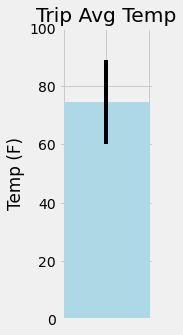

In [108]:
plt.figure(figsize= (1.5,5))
average = calc_temps(start_date, last_date)[0][1]
temp_min = calc_temps(start_date, last_date)[0][0]
temp_max =calc_temps(start_date, last_date)[0][2]
plt.bar(1,height = average, yerr = (temp_max-temp_min)/2,  width = 0.01, color = 'lightblue')
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylim([0,100])

plt.show()

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
average = calc_temps(start_date, last_date)[0][1]
temp_min = calc_temps(start_date, last_date)[0][0]
temp_max =calc_temps(start_date, last_date)[0][2]

# Plot
plt.figure(figsize= (1.5,5))
plt.bar(1,height = average, yerr = (temp_max-temp_min)/2,  width = 0.01, color = 'lightblue')

# Format plot
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylim([0,100])

# Display plot
plt.show()

In [123]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
hawaii_df = measure_df.merge(station_df, on = 'station')
hawaii_df = hawaii_df.loc[hawaii_df['date'] >= '2016-08-23']
hawaii_df.head()

rain_station = pd.DataFrame(hawaii_df.groupby(['station', 'name', 'latitude','longitude','elevation'])['prcp'].sum())
rain_station = pd.DataFrame(rain_station['prcp'].sort_values())
rain_station.head()

,,,,,prcp
station,name,latitude,longitude,elevation,
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [124]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
daily_normals("08-23")

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(67.0, 76.6923076923077, 87.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
